# Telco Churn Final Report

Understanding the predictors of churn among telecommuncations customers at Telco

## Key Take-Aways From This Report <a name='keytakeaways'></a>
- $\approx 0.27$ of customers are churning per month
- Customers with month-to-month, fiber optic service, and electronic check are high predictors of churn; in addition, churned customers tend to pay more per-month.
- A decision tree model is $\approx 0.77$ accurate
- Recommendation: 
    1. Promote longer contracts, and services that correctly meet customer needs (perhaps through additional services). 
    2. Reduce monthly charges early on in a customer relationship by offering discounts
    
<a href='#conclusion'>Last Slide: Conclusion</a> - <a href='#introduction'>Next: Introduction</a>

## Final Reports Contents <a name='contents'></a>

1. <a href='#introduction'>Introduction</a>
    1. <a href='#goals'>Goals and Deliverables</a>
    2. <a href='#hypothesis'>Initial Hypothesis/Questions</a>
2. <a href='#dataintro'>Introduction to the Data</a>
3. <a href='#acquire'>Acquire Data</a>
4. <a href='#prepare'>Prepare Data</a>
5. <a href='#explore'>Explore Data</a>
    1. <a href='#churn'>How bad is churn?</a>
    1. <a href='#tenure'>How long have churned customers been with the company?</a>
    2. <a href='#permonth'>Are churned customers paying more per month?</a>
    3. <a href='#churncontract'>Is churn associated with a contract type?</a>
    4. <a href='#churninternettype'>Is churn associated with internet service type?</a>
    5. <a href='#electroniccheck'>Is churn associated with electronic (non-automatic) payments </a>
    6. <a href='#explorediscussion'>Exploration discussion </a>
6. <a href='#modeling'>Machine Learning Model of Churn</a>
    1. <a href='#encode'>Encode Variables</a>
    2. <a href='#baseline'>Baseline Model</a>
    3. <a href='#xysets'>Subset into X and y subsets</a>
    4. <a href='#models'>Candidate Models</a>
        4. <a href='#knneighbors'>K Nearest Neighbors Model</a>
        5. <a href='#decisiontree'>Decision Tree Model</a>
        6. <a href='#randomforest'>Random Forest Model</a>
        7. <a href='#logisticreg'>Logistic Regression Model</a>
    5. <a href='#comparing'>Comparing Models</a>
    6. <a href='#modeldiscussion'>Machine Learning Model Discussion</a>
7. <a href='#test'>Testing the Model</a>
8. <a href= '#recommendations'>Recommendations</a>
9. <a href='#conclusion'>Conclusion</a>

The following Python modules and constants are used in this project:

In [1]:
import pandas as pd
import itertools
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import acquire
import prepare

rand_seed = prepare.RAND_SEED #to use for the model building
alpha = 0.05 #used for hypothesis testing

## Introduction <a name='introduction'></a>

This project explores the Telco data set to determine the variables of customer churn. It includes the full data science pipline: acquiring and cleaning the data, exploring and visualizing the data, and finally using a model to predict churn.

### Goals and Deliverables <a name='goals'></a>

- Goals
	- Identify at least 3 variables that predict churn
	- A model that is at least 0.75 accurate
	- A report communicating the data science pipeline process
- Deliverables
	- A final report Jupyter Notebook with clean code
	- Python modules automating the acquire and preparation of the data
	- A CSV of data predictions

### Initial Hypothesis/Questions <a name='hypothesis'></a>

- I expect that contract and payment types are the most important predictors of churn
	- People who pay more and see it every month are reminded of the money they are spending and can make a value judgement on whether or not they want to spend their money
- Are additional services important parts of churn?
	- Are people more reluctant to leave the company if they have certain services?

<a href='#keytakeaways'>Prev: Key Takeaways</a> - <a href='#churn'>Next: Churn</a>

<a href='#contents'>To Top</a>

## Introduction to the Data <a name='dataintro'></a>

Every row in the data represents an individual customer, and includes data on their relationship with the Telco company.  Each customer has a unique ID consisting of numerics and alphabetic chars.  Basic demographic information is available, consisting of gender, partner status, dependent status, and senior citizen status.  The rest of the columns contain information on the customer's relationship with the company.  

#### Customer Identification and Demographic Data:
- Customer ID (String)
- Gender (Male/Female)
- Partner status (Bool)
- Dependent status (Bool)
- Senior citizen status (Bool)

#### Customer Relationship information:
- Tenure in months (float)
- Monthly charges (\$USD) (float)
- Total charges (\$USD) (float)
- Paperless Billing (Bool)
- Payment type (categorical)
- Phone Service, with service option columns:
    - Multiple lines : One Line, Multiple Lines, No Phone Service (categorical)
- Internet Service Type: Fiber Optic, DSL, None (categorical)
- Internet Service Option columns (all bool):
    - Online security
    - Online backup
    - Device protection
    - Tech support
    - Streaming TV
    - Streaming movies
- Churn status (bool)


<a href='#contents'>To Top</a>

## Acquire the Data <a name='acquire'></a>

A custom acquire module is used to retrieve the data from the CodeUp MySQL database.  This module includes the following function signature:
- `get_telco_data(query_db=False)` : Queries the database, or-if a `telco.csv` is present-opens a file to retrieve the data needed for this project.  The data is then cast to a DataFrame and returned to the call location.
    - `query_db=True` will force a database query even if a `telco.csv` file is present, and the existing `telco.csv` file will be overwritten.
    
The following MySQL command is used:

`SELECT c.*, ct.contract_type, pt.payment_type, iso.internet_service_type
    FROM customers AS c
        JOIN contract_types AS ct USING (contract_type_id)
        JOIN payment_types AS pt USING (payment_type_id)
        JOIN internet_service_types AS iso USING (internet_service_type_id);`

In [2]:
df = acquire.get_telco_data() # call the custom function and store returned dataframe in the df variable
df.head(3) # display the first three rows of the dataframe variable

Returning saved csv file.


,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,2,Yes,2,65.6,593.3,No,One year,Mailed check,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,No,1,Yes,1,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic


In [3]:
df.info() #display the column and type information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   customer_id               7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   internet_service_type_id  7043 non-null   int64  
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14  streamin

Key acquire take-aways:
- 7043 rows are retrieved and 24 columns are retrieved

<a href='#contents'>To Top</a>

## Prepare the Data <a name='prepare'></a>


A custom module is used to prepare the data acquired from the database.  It contains the following relevant function signature:
- `prep_telco(df)` : Given the acquired dataframe, this drops the foreign keys from the SQL. It also drops the rows without a `total_charges` value; `total_charges` are then cast to `float` data type. Returns a prepared dataframe object.
    - The rows dropped in `total_charges` are rows that have `tenure=0`; a `total_charges` of $0$ could be infered--however, there are only $11$ rows where this happens and therefore it represents only $0.0016$ of the original date, i.e. not enough rows to make a difference.
- `split_telco_data(df)` : Given a prepared dataframe, this will return train, validate and test subsets of the dataframe.
    - The `statify` parameter is used for `sklearn.model_selection.test_train_split()` to ensure that churned customers are equally distributed over the subsets

(More information on the code that these functions are made of can be seen in the `prepare.py` comments, and in the `README.md` appendices.

In [4]:
#display the rows that will be dropped
df[df.total_charges == ' '][['customer_id', 'tenure', 'monthly_charges', 'total_charges']]

,customer_id,tenure,monthly_charges,total_charges
945,1371-DWPAZ,0,56.05,
1731,2520-SGTTA,0,20.00,
1906,2775-SEFEE,0,61.90,
2025,2923-ARZLG,0,19.70,
2176,3115-CZMZD,0,20.25,
2250,3213-VVOLG,0,25.35,
2855,4075-WKNIU,0,73.35,
3052,4367-NUYAO,0,25.75,
3118,4472-LVYGI,0,52.55,
4054,5709-LVOEQ,0,80.85,


These are the eleven rows that have a single space char for total charges.

In [5]:
df_prep = prepare.prep_telco(df) #split the dataframe into three subsets
train, validate, test = prepare.split_telco_data(df_prep)
train.head(3)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
5919,8331-ZXFOE,Female,0,No,No,58,Yes,Yes,Yes,Yes,...,Yes,No,No,Yes,71.10,4299.20,No,One year,Credit card (automatic),DSL
1915,2790-XUYMV,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,...,No,No,No,Yes,85.45,6028.95,No,One year,Credit card (automatic),Fiber optic
5054,7107-UBYKY,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,25.75,882.55,No,Month-to-month,Electronic check,None


In [6]:
train.shape #there are 3943 rows and 25 columns

(3937, 21)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3937 non-null   object 
 1   gender                 3937 non-null   object 
 2   senior_citizen         3937 non-null   int64  
 3   partner                3937 non-null   object 
 4   dependents             3937 non-null   object 
 5   tenure                 3937 non-null   int64  
 6   phone_service          3937 non-null   object 
 7   multiple_lines         3937 non-null   object 
 8   online_security        3937 non-null   object 
 9   online_backup          3937 non-null   object 
 10  device_protection      3937 non-null   object 
 11  tech_support           3937 non-null   object 
 12  streaming_tv           3937 non-null   object 
 13  streaming_movies       3937 non-null   object 
 14  paperless_billing      3937 non-null   object 
 15  m

Key prepare take-aways:
- 11 rows are dropped due to lack of data in the `total_charges` column
- Data is split into train, validate, and test subsets

<a href='#contents'>To Top</a>

## Exploring the Data <a name='explore'></a>

*Notes*: Only `monthly_charges` and `tenure` are used to illustrate the exploration of numeric data, and hypothesis testing is performed only on `monthly_charges`. Only `contract_type`, `internet_service_type`, and `payment_type` categories are used to illustrate the exploration of categorical data.  See <a href='#appendix'>appendix</a> for more details on other categories.

### How bad is churn? <a name='churn'></a>

The `train` data set is used to explore the data. 

The first to understand is the extent of churn within the data.

Key take-aways:
- Churn rate for the overall sample is $\approx0.27$
- This represents $\approx1000$ customers

<a href='#introduction'>Prev: Introduction</a> - <a href='#tenure'>Next: How long have churned customers been with the company?</a>

<a href='#contents'>To Top</a>

In [77]:
train.churn.value_counts() #get the values of the churn column

No     2891
Yes    1046
Name: churn, dtype: int64

In [9]:
proportion_churn = (train.churn == 'Yes').mean() #get the proportion of customers who churn
proportion_churn

0.2656845313690627

Text(0, 0.5, 'Customer count')

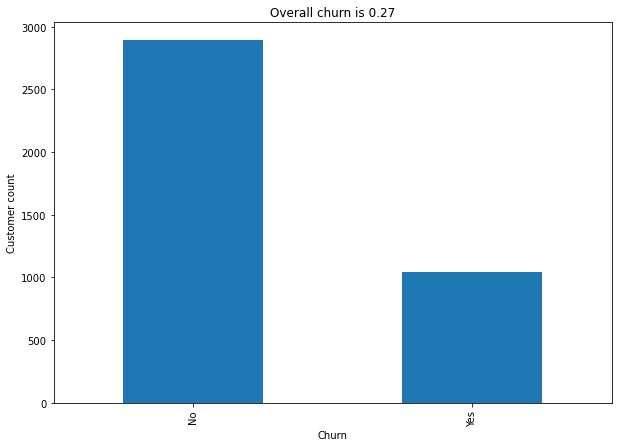

In [10]:
# plot the churn proortions
plt.figure(figsize=(10,7)) # make figure larger
train.churn.value_counts().plot.bar() # make the bar plot with the data
plt.title(f'Overall churn is {proportion_churn:.2}') # set the plot title
plt.xlabel('Churn') # Set the x-axis label
plt.ylabel('Customer count') # set y-axis label

About $0.27$ of customers are churning.

### How long have churned customers been with the company? <a name='tenure'></a>

#### Visualize

<a href='#churn'>Prev: How bad is churn?</a> - <a href='#permonth'>Next: Are churned customers paying more per month?</a>

<a href='#contents'>To Top</a>

In [11]:
#make a dataframe of just the numeric columns and churn
train_numerics = train[['tenure', 'monthly_charges', 'total_charges', 'churn']]

Text(0.5, 0, 'Churn')

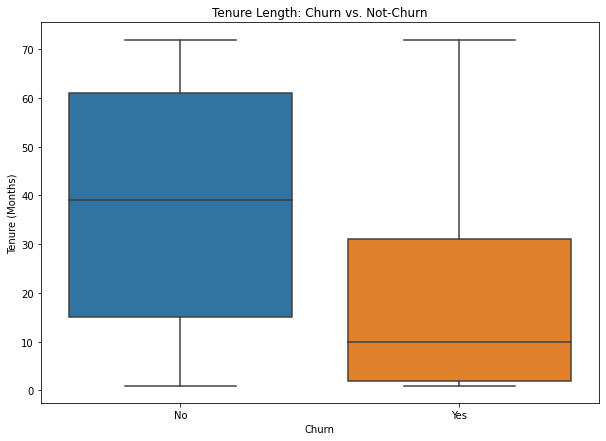

In [12]:
plt.figure(figsize=(10,7)) # make figure larger
sns.boxplot(data=train_numerics, x='churn', y='tenure') #plot monthly charges
plt.title(f'Tenure Length: Churn vs. Not-Churn') # set the plot title
plt.ylabel('Tenure (Months)') #set ylabel
plt.xlabel('Churn') #set x label

As can be seen from the box plot, churning customers have not been with the company for as long as non-churning customers.


<a href='#contents'>To Top</a>

In [13]:
#same data numerically
train_numerics.groupby('churn')['tenure'].describe().T

churn,No,Yes
count,2891.000000,1046.000000
mean,38.003459,18.325048
std,24.177715,19.960763
min,1.000000,1.000000
25%,15.000000,2.000000
50%,39.000000,10.000000
75%,61.000000,31.000000
max,72.000000,72.000000


### Are churned customers paying more per month? <a name = 'permonth'></a>


#### Visualize

<a href='#tenure'>Prev: How long have churned customers been with the company?</a> - <a href='#churncontract'>Next:Is churn associated with a contract type?</a>

<a href='#contents'>To Top</a>

Text(0.5, 0, 'Churn')

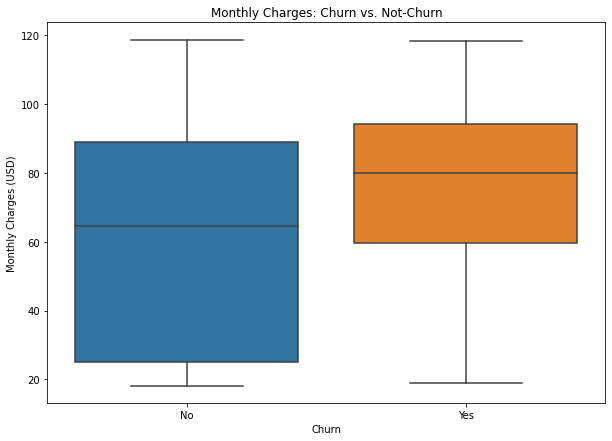

In [14]:
plt.figure(figsize=(10,7)) # make figure larger
sns.boxplot(data=train_numerics, x='churn', y='monthly_charges') #plot monthly charges
plt.title(f'Monthly Charges: Churn vs. Not-Churn') # set the plot title
plt.ylabel('Monthly Charges (USD)') #set ylabel
plt.xlabel('Churn') #set x label

The monthly charges for churning customers are higher than for non-churning customers.


In [15]:
# same information numerically
train_numerics.groupby('churn')['monthly_charges'].describe().T

churn,No,Yes
count,2891.000000,1046.000000
mean,61.218091,74.719216
std,31.349533,24.593969
min,18.250000,18.850000
25%,25.000000,59.525000
50%,64.500000,79.850000
75%,89.025000,94.237500
max,118.650000,118.350000


#### Perform hypothesis testing

Consider the distribution of monthly charges.  It is roughly normally distributed.  See graph below, and that the mean and median are different by $\approx 6$ (normally distributed $\implies \text{mean} = \text{median}$).  Therefore perform a t-test on the column.

<AxesSubplot:>

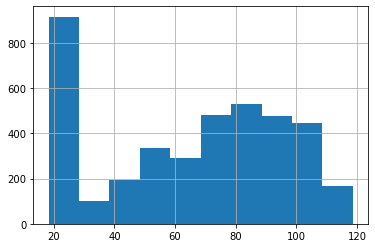

In [16]:
train.monthly_charges.hist() #histogram of the monthly charges

In [17]:
train.monthly_charges.mean(), train.monthly_charges.median() #view the mean and median of the monthly_charges column

(64.80513081026147, 70.25)

Perform a t-test to determine the following:

$H_0$ : The mean monthly charges among churned customers is *less than or equal to* that of unchurned customers

$H_a$ : The mean monthly charges among churned customers is *greater than* that of unchurned customers

In [18]:
#split the data into churn and non-chun sets
churn_series = train[train.churn == 'Yes'].monthly_charges
nochurn_series = train[train.churn == 'No'].monthly_charges

#use levene test to see if the variance are equal
l_t, l_p = stats.levene(churn_series, nochurn_series)
levene_bool = not l_p < alpha
    #now do the t test
# calculate the statistics
t, p = stats.ttest_ind(churn_series, nochurn_series, equal_var= levene_bool)
p/2 < alpha, p

(True, 2.460130776937842e-43)

In [19]:
if p/2 < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion*: The mean monthly charges is most likely higher among customers who churn than those who do not churn."

Key take away:
- Churned customers are paying more per month
    - `total_charges` can be inferred from the `monthly_charges` column.  
    
<a href='#contents'>To Top</a>

### Is churn associated with a contract type? <a name='churncontract'></a>

<a href='#permonth'>Prev: Are churned customers paying more per month?</a> - <a href='#churninternettype'>Next: Is churn associated with internet service type?</a>

#### Visualize

Consider churn among different contract types.

Three contract types: Month-to-Month, One Year, Two Year

Text(0, 0.5, 'Number of customers')

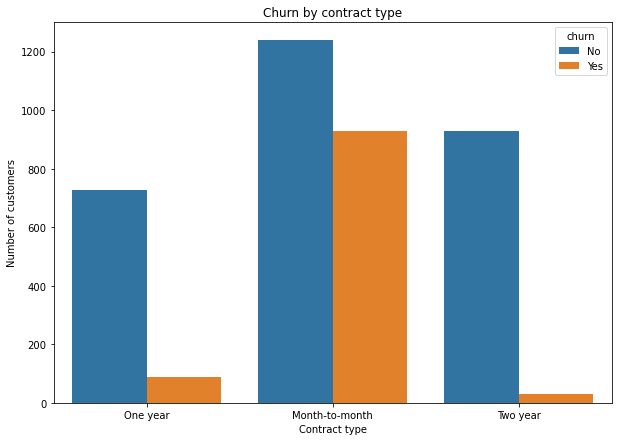

In [20]:
plt.figure(figsize=(10,7)) # make figure larger
sns.countplot(data=train, x='contract_type', hue='churn') # plot the data
plt.title('Churn by contract type') # set title
plt.xlabel('Contract type') #set x label
plt.ylabel('Number of customers') # set y label

Month-to-Month contract types disproportionately churn.

In [21]:
#proportion shown numerically:
# group the data by contract type an calculate the count of rows for each one
pd.DataFrame(train.groupby('contract_type').churn.value_counts()) 

churn
contract_type  churn       
Month-to-month No      1238
               Yes      927
One year       No       726
               Yes       89
Two year       No       927
               Yes       30

In [22]:
#as a percentage
pd.crosstab(train.contract_type, train.churn).apply(lambda r: r/r.sum(), axis=1)

churn,No,Yes
contract_type,,
Month-to-month,0.571824,0.428176
One year,0.890798,0.109202
Two year,0.968652,0.031348


#### Perform hypothesis testing

Visually and numerically it appears that month-to-month customers. Perform hypothesis testing on the following:

$H_0$ : Month to month contracts are independent of churn.

$H_a$ : Month to month contracts are not independent of churn.

In [23]:
#seperate out the categories into dataframes
contract_hypothesis = train[['churn', 'contract_type']]
contract_hypothesis['monthly_contract'] = (contract_hypothesis.contract_type == 'Month-to-month')

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_42712/977381110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_hypothesis['monthly_contract'] = (contract_hypothesis.contract_type == 'Month-to-month')


In [24]:
#make the crosstab with dataframes
obs = pd.crosstab(contract_hypothesis.churn, contract_hypothesis.monthly_contract)
#calculate the statistics
chi2, p, degf, expected = stats.chi2_contingency(obs)
chi2, p

(649.1331915563476, 3.4484593947893894e-143)

In [25]:
if p < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion*: Churn is most likely dependent on churn.

Key take away:
- Because of the high $χ^2$  value, it is very likely that churn is not independent on Month-to-Month contract status

<a href='#contents'>To Top</a>

### Is churn associated with internet service type? <a name='churninternettype'></a>


<a href='#churncontract'>Prev: Is churn associated with a contract type?</a> - <a href='#electroniccheck'> Next: Is churn associated with electronic check?</a>


#### Visualize

Consider customers by their internet service type.

Text(0, 0.5, 'Number of customers')

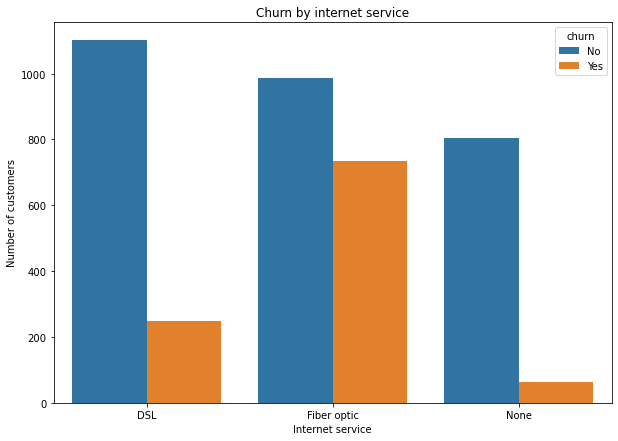

In [26]:
plt.figure(figsize=(10,7)) # make figure larger
sns.countplot(data=train, x='internet_service_type', hue='churn') #plot the data
plt.title('Churn by internet service') #set the title
plt.xlabel('Internet service') #set the xlabel
plt.ylabel('Number of customers') #set the ylabel

Fiber optic internet service customers disproportionately churn

In [27]:
#same information but numerically
pd.DataFrame(train.groupby('internet_service_type').churn.value_counts()) 

churn
internet_service_type churn       
DSL                   No      1101
                      Yes      247
Fiber optic           No       987
                      Yes      735
None                  No       803
                      Yes       64

In [28]:
#as a percentage
pd.crosstab(train.internet_service_type, train.churn).apply(lambda r: r/r.sum(), axis=1)

churn,No,Yes
internet_service_type,,
DSL,0.816766,0.183234
Fiber optic,0.573171,0.426829
None,0.926182,0.073818


#### Perform Hypothesis Testing

Visually and numerically it appears that there is a higher rate of churn among fiber optic customers.  Perform hypothesis testing on the following:

$H_0$ : Fiber optic contracts are independent of churn.

$H_a$ : Fiber optic contract are not independent of churn.

In [76]:
#seperate out subsets
contract_hypothesis = train[['churn', 'internet_service_type']]
contract_hypothesis['fiber_optic_service'] = (contract_hypothesis.internet_service_type == 'Fiber optic')

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_42712/821018884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_hypothesis['fiber_optic_service'] = (contract_hypothesis.internet_service_type == 'Fiber optic')


In [30]:
#make a crosstab
obs = pd.crosstab(contract_hypothesis.churn, contract_hypothesis.fiber_optic_service)
#calculate stats
chi2, p, degf, expected = stats.chi2_contingency(obs)
chi2, p

(405.92112170517066, 2.831419548361709e-90)

In [31]:
if p < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion* Fiber optic service is a likely driver of churn.

Key take away:
- Because of the high $χ^2$  value, it is very likely that churn is not independent on fiber optic service status.

<a href='#contents'>To Top</a>

### Is churn associated with electronic check? <a name='electroniccheck'></a>

<a href='#churninternettype'> Prev: Is churn associated with internet service type?</a> - <a href='#modeling'>Next: Machine Learning Model of Churn</a>
#### Visualize

Text(0, 0.5, 'Number of customers')

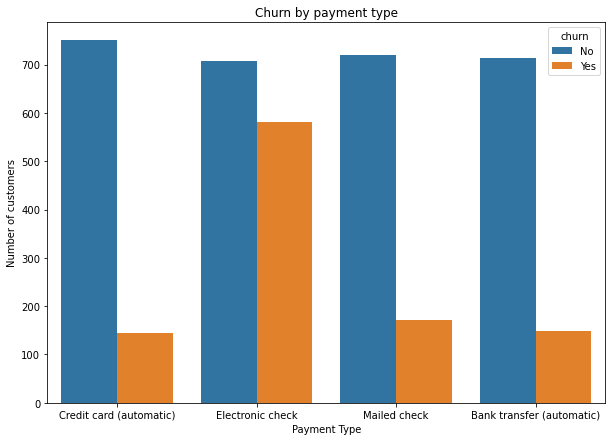

In [32]:
plt.figure(figsize=(10,7)) # make figure larger
sns.countplot(data=train, x='payment_type', hue='churn') #plot the data
plt.title('Churn by payment type') #set the title
plt.xlabel('Payment Type') #set the x label
plt.ylabel('Number of customers') # set the y label

Electronic check payment customers disproportionately churn.

In [33]:
#same information but numerically
pd.DataFrame(train.groupby('payment_type').churn.value_counts()) 

churn
payment_type              churn       
Bank transfer (automatic) No       713
                          Yes      149
Credit card (automatic)   No       750
                          Yes      145
Electronic check          No       708
                          Yes      581
Mailed check              No       720
                          Yes      171

In [34]:
pd.crosstab(train.payment_type, train.churn).apply(lambda r: r/r.sum(), axis=1)

churn,No,Yes
payment_type,,
Bank transfer (automatic),0.827146,0.172854
Credit card (automatic),0.837989,0.162011
Electronic check,0.549263,0.450737
Mailed check,0.808081,0.191919


#### Perform hypothesis testing

Visually and numerically it looks like electronic check payment is dependent to churn. Hypothesis test the following:

$H_0$ : Electronic check payments are independent of churn.

$H_a$ : Electronic check payments are not independent of churn.

In [35]:
#seperate out subsets
contract_hypothesis = train[['churn', 'payment_type']]
contract_hypothesis['electronic_check'] = (contract_hypothesis.payment_type == 'Electronic check')

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_42712/3338668490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract_hypothesis['electronic_check'] = (contract_hypothesis.payment_type == 'Electronic check')


In [36]:
# make a crosstab
obs = pd.crosstab(contract_hypothesis.churn, contract_hypothesis.electronic_check)
#calculate the stats
chi2, p, degf, expected = stats.chi2_contingency(obs)
chi2, p

(334.97978026680926, 7.910587922260644e-75)

In [37]:
if p < alpha:
    print('Null hypothesis is likely false')
else:
    print('Null hypothesis is likely true')

Null hypothesis is likely false


*Conclusion* Electronic checks are a likely driver of churn.

Key take away:
- Because of the high $χ^2$  value, it is very likely that churn is not independent of electronic check payments.

<a href='#contents'>To Top</a>

### Exploration discussion <a name='explorediscussion'></a>

As can be easily seen from the visualizations and the hypothesis testing above churned customers have a higher mean monthly charge rate, are likely to be fiber optic customers, are likely to be paying month-to-month, and are likely to be paying by electronic check.  Other factors were also tested (see <a href='#appendix'>appendices</a>) and found to be likely dependent on churn. Speculating causation, these variables indicate that a customer's willingness to pay for the service they receive is lower than their monthly payment; they are then reminded of this difference every month when they are balancing their checkbook. Any solution to the churn problem at Telco must better the product or decrease the monthly cost.


<a href='#contents'>To Top</a>

## Machine Learning Model of Churn <a name='modeling'></a>

Using machine learning require the following steps:
- Encode all variables to numerics
- Make a baseline model
- Subset data into X and y (target variable) sets
- Fit a model using train data
- Use a validate subset to determine the best model out of all candidate models
- Test accuracy of top performing model on the test subset of the data set

For more information on why these four models and their hyperparameters were used, please see the <a href='#appendix'>appendices</a>.

<a href='#electroniccheck'>Prev: Is churn associated with electronic check?</a> - <a href='#baseline'>Next: Baseline Model</a>

In [38]:
compare_models = [] # this will store the metrics for each model so that they can be easily compared.

### Encode Variables <a name='encode'></a>

A custom function in the `prepare.py` module is used to encode the non-numeric data.  It has the following function signature:
- `telco_make_dummies(df)` : Given a dataframe object, `df`, the non-numeric data is encoded into numeric data. The returned dataframe will be the original with the encoded columns concatenated.

In [39]:
#encode the data sets
train = prepare.telco_make_dummies(train)
validate = prepare.telco_make_dummies(validate)
test = prepare.telco_make_dummies(test)

### Baseline Model <a name='baseline'></a>

In order to ensure the quality and accuracy of the machine learning models of churn, they should be compared to a baseline model
that predict a single outcome for all customers.  This outcome is determined by choosing the most common target outcome variable within the sample.  In this case, since $\approx 0.27$ of customers churn, the baseline models predicts that no customers churn for an accuracy of $1 - 0.27 = 0.73$.

<a href='#modeling'>Prev: Machine Learning Model of Churn</a> - <a href='#comparing'>Next: Comparing Candidate Models </a>

In [40]:
#make a baseline model
#most of the customers do not churn. baseline model is no one churns
baseline_prediction = train.churn_Yes.value_counts().idxmax() #get most common value
baseline_model = pd.Series([baseline_prediction for x in range(train.shape[0])]) #make a dataframe with the predictions

#save accuracy in a variable and product e classification report
baseline_accuracy = metrics.classification_report(train.churn_Yes, baseline_model, labels = [0, 1], zero_division=True, output_dict=True)['accuracy']
pd.DataFrame(metrics.classification_report(train.churn_Yes, baseline_model, labels = [0, 1], zero_division=True, output_dict=True)).T

,precision,recall,f1-score,support
0,0.734315,1.000000,0.846807,2891.000000
1,1.000000,0.000000,0.000000,1046.000000
accuracy,0.734315,0.734315,0.734315,0.734315
macro avg,0.867158,0.500000,0.423404,3937.000000
weighted avg,0.804904,0.734315,0.621824,3937.000000


In [41]:
print(f'Baseline model accuracy is {baseline_accuracy}')

Baseline model accuracy is 0.7343154686309372


### Make X and y sets. <a name='xysets'></a>

The `X_sampleName` sets contain all the encoded data from the sample except the target variable, and the `y_sampleName` set contains the target variable data.

In [42]:
# make the X and y train sets
#include all numeric columns and except the target variable
X_train = train.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = 'churn_Yes')
#include only the encoded target variable
y_train = train.churn_Yes

# make the X and y validate sets
#include all numeric columns and except the target variable
X_validate = validate.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = 'churn_Yes')
#include only the encoded target variable
y_validate = validate.churn_Yes

<a href='#contents'>To Top</a>

### Candidate Models <a name='models'></a>

#### K Nearest Neighbors<a name='knneighbors'></a>

K-nearest neighbors is a geometric classification algorithm that determines group membership by considering the $k$ nearest points' classification.

In [43]:
knn = KNeighborsClassifier(n_neighbors=17) #make a KNN model
knn = knn.fit(X_train, y_train) #fit the model
y_pred_train = knn.predict(X_train) #see predictions for train set
metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict=True) #save accuracy
pd.DataFrame(metrics_dict_train).T

,precision,recall,f1-score,support
0,0.816511,0.937392,0.872786,2891.00000
1,0.707120,0.417782,0.525240,1046.00000
accuracy,0.799340,0.799340,0.799340,0.79934
macro avg,0.761815,0.677587,0.699013,3937.00000
weighted avg,0.787447,0.799340,0.780448,3937.00000


In [44]:
y_pred_validate = knn.predict(X_validate) #predict for validate
metrics_dict_validate = metrics.classification_report(y_validate, y_pred_validate, output_dict=True) #save accuracy
pd.DataFrame(metrics_dict_validate).T

,precision,recall,f1-score,support
0,0.816396,0.925460,0.867514,1033.000000
1,0.673729,0.425134,0.521311,374.000000
accuracy,0.792466,0.792466,0.792466,0.792466
macro avg,0.745063,0.675297,0.694413,1407.000000
weighted avg,0.778473,0.792466,0.775488,1407.000000


In [45]:
#store a comparison dictionary for later comparison with other models
KNN_compare = {
    'Model':'K-nearest Neighbors',
    'Train Accuracy' : metrics_dict_train['accuracy'],
    'Train Sensitivity': metrics_dict_train['1']['recall'],
    'Validate Accuracy' : metrics_dict_validate['accuracy'],
    'Validate Sensitivity': metrics_dict_validate['1']['recall'],
    'Better than Baseline' : metrics_dict_train['accuracy'] > baseline_accuracy and metrics_dict_validate['accuracy'] > baseline_accuracy,
    'Accuracy Difference' : abs(metrics_dict_train['accuracy'] - metrics_dict_validate['accuracy'])
}
compare_models.append(KNN_compare)

<a href='#contents'>To Top</a>


#### Decision Tree Model <a name='decisiontree'></a>

The decision tree algorithm makes a binary tree decision to predict outcome.  It is given a maximum depth variable, representing the number of nodes seperating a leaf node and the root node.

In [46]:
dt = DecisionTreeClassifier(max_depth=4, random_state=rand_seed) #make a decision tree model with depth 4
dt = dt.fit(X_train, y_train) #fit the train data
y_pred_train = dt.predict(X_train) #predict the train data
metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict=True) #save accuracy information
pd.DataFrame(metrics_dict_train).T

,precision,recall,f1-score,support
0,0.824399,0.925631,0.872087,2891.00000
1,0.688857,0.455067,0.548071,1046.00000
accuracy,0.800610,0.800610,0.800610,0.80061
macro avg,0.756628,0.690349,0.710079,3937.00000
weighted avg,0.788388,0.800610,0.786001,3937.00000


In [47]:
y_pred_validate = dt.predict(X_validate) #predict for validate
metrics_dict_validate = metrics.classification_report(y_validate, y_pred_validate, output_dict=True) #save accuracy
pd.DataFrame(metrics_dict_validate).T

,precision,recall,f1-score,support
0,0.830688,0.911907,0.869405,1033.000000
1,0.666667,0.486631,0.562597,374.000000
accuracy,0.798863,0.798863,0.798863,0.798863
macro avg,0.748677,0.699269,0.716001,1407.000000
weighted avg,0.787089,0.798863,0.787851,1407.000000


In [48]:
#store a comparison dictionary for later comparison with other models
DT_compare = {
    'Model':'Decision Tree',
    'Train Accuracy' : metrics_dict_train['accuracy'],
    'Train Sensitivity': metrics_dict_train['1']['recall'],
    'Validate Accuracy' : metrics_dict_validate['accuracy'],
    'Validate Sensitivity': metrics_dict_validate['1']['recall'],
    'Better than Baseline' : metrics_dict_train['accuracy'] > baseline_accuracy and metrics_dict_validate['accuracy'] > baseline_accuracy,
    'Accuracy Difference' : abs(metrics_dict_train['accuracy'] - metrics_dict_validate['accuracy'])
}
compare_models.append(DT_compare)

<a href='#contents'>To Top</a>


#### Random Forest Model <a name='randomforest'></a>

A random forest model uses multiple decision trees to predict target variable outcome; this introduces some randomness into the model--therefore preventing overfitting.

In [49]:
rf = RandomForestClassifier(min_samples_leaf = 9, max_depth = 9, random_state=rand_seed) #make a random forest model with depth 4
rf = rf.fit(X_train, y_train) #fit the train data
y_pred_train = rf.predict(X_train) #predict the train data
metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict=True) #save accuracy information
pd.DataFrame(metrics_dict_train).T

,precision,recall,f1-score,support
0,0.848763,0.925977,0.885691,2891.000000
1,0.726692,0.543977,0.622198,1046.000000
accuracy,0.824486,0.824486,0.824486,0.824486
macro avg,0.787728,0.734977,0.753944,3937.000000
weighted avg,0.816331,0.824486,0.815685,3937.000000


In [50]:
y_pred_validate = rf.predict(X_validate) #predict for validate
metrics_dict_validate = metrics.classification_report(y_validate, y_pred_validate, output_dict=True) #save accuracy
pd.DataFrame(metrics_dict_validate).T

,precision,recall,f1-score,support
0,0.846293,0.906099,0.875175,1033.000000
1,0.677741,0.545455,0.604444,374.000000
accuracy,0.810235,0.810235,0.810235,0.810235
macro avg,0.762017,0.725777,0.739810,1407.000000
weighted avg,0.801489,0.810235,0.803211,1407.000000


In [51]:
#store a comparison dictionary for later comparison with other models
RF_compare = {
    'Model':'Random Forest',
    'Train Accuracy' : metrics_dict_train['accuracy'],
    'Train Sensitivity': metrics_dict_train['1']['recall'],
    'Validate Accuracy' : metrics_dict_validate['accuracy'],
    'Validate Sensitivity': metrics_dict_validate['1']['recall'],
    'Better than Baseline' : metrics_dict_train['accuracy'] > baseline_accuracy and metrics_dict_validate['accuracy'] > baseline_accuracy,
    'Accuracy Difference' : abs(metrics_dict_train['accuracy'] - metrics_dict_validate['accuracy'])
}
compare_models.append(RF_compare)

<a href='#contents'>To Top</a>


#### Logistic Regression Model <a name='logisticreg'></a>

A logistic regression model uses a regression formula to make a binary prediction in target variable outcomes.

In [52]:
lr = LogisticRegression(random_state = rand_seed, max_iter=1000,  solver='liblinear') #make a random forest model with depth 4
lr = lr.fit(X_train, y_train) #fit the train data
y_pred_train = rf.predict(X_train) #predict the train data
metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict=True) #save accuracy information
pd.DataFrame(metrics_dict_train).T

,precision,recall,f1-score,support
0,0.848763,0.925977,0.885691,2891.000000
1,0.726692,0.543977,0.622198,1046.000000
accuracy,0.824486,0.824486,0.824486,0.824486
macro avg,0.787728,0.734977,0.753944,3937.000000
weighted avg,0.816331,0.824486,0.815685,3937.000000


In [53]:
y_pred_validate = lr.predict(X_validate) #predict for validate
metrics_dict_validate = metrics.classification_report(y_validate, y_pred_validate, output_dict=True) #save accuracy
pd.DataFrame(metrics_dict_validate).T

,precision,recall,f1-score,support
0,0.853186,0.894482,0.873346,1033.000000
1,0.663580,0.574866,0.616046,374.000000
accuracy,0.809524,0.809524,0.809524,0.809524
macro avg,0.758383,0.734674,0.744696,1407.000000
weighted avg,0.802786,0.809524,0.804952,1407.000000


In [54]:
#store a comparison dictionary for later comparison with other models
LR_compare = {
    'Model':'Logistic Regression',
    'Train Accuracy' : metrics_dict_train['accuracy'],
    'Train Sensitivity': metrics_dict_train['1']['recall'],
    'Validate Accuracy' : metrics_dict_validate['accuracy'],
    'Validate Sensitivity': metrics_dict_validate['1']['recall'],
    'Better than Baseline' : metrics_dict_train['accuracy'] > baseline_accuracy and metrics_dict_validate['accuracy'] > baseline_accuracy,
    'Accuracy Difference' : abs(metrics_dict_train['accuracy'] - metrics_dict_validate['accuracy'])
}
compare_models.append(LR_compare)

<a href='#contents'>To Top</a>

### Comparing Candidate Models <a name='comparing'></a>

As the accuracy results have been saved in `compare_models` list, they can be easily comapared:

<a href='#baseline'>Prev: Baseline Model</a> - <a href='#evaluation'>Next: Evaluating the model</a>

<a href='#contents'>To Top</a>

In [55]:
#make the comparison dataframe and display it
compare_df = pd.DataFrame(compare_models)
compare_df.set_index('Model')

,Train Accuracy,Train Sensitivity,Validate Accuracy,Validate Sensitivity,Better than Baseline,Accuracy Difference
Model,,,,,,
K-nearest Neighbors,0.799340,0.417782,0.792466,0.425134,True,0.006873
Decision Tree,0.800610,0.455067,0.798863,0.486631,True,0.001747
Random Forest,0.824486,0.543977,0.810235,0.545455,True,0.014251
Logistic Regression,0.824486,0.543977,0.809524,0.574866,True,0.014962


*Note*: `Better than Baseline` represents a logical conjunction: the model has a higher accuracy than the baseline for both the train and validate sample sets.

Text(0, 0.5, 'Accuracy')

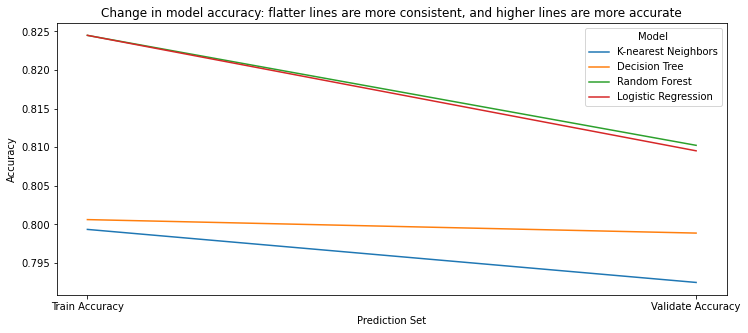

In [56]:
#graphically show the change in the model accuracy
#melt the data frame
melted_compare_df = compare_df[['Model','Train Accuracy', 'Validate Accuracy']].melt(id_vars='Model')
melted_compare_df
#graph the melted data frame
plt.figure(figsize=(12,5))
sns.lineplot(x='variable', y='value', hue='Model', data = melted_compare_df)
#set labels
plt.title('Change in model accuracy: flatter lines are more consistent, and higher lines are more accurate')
plt.xlabel('Prediction Set')
plt.ylabel('Accuracy')

The above graph shows the change in accuracy from the train and validate.  A flat line indicates that the model is more consistent across both data sets, and a higher line indicates a more accurate model.

### Machine Learning Model Discussion <a name='modeldiscussion'></a>

Accuracy is the primary metric used to evaluate the model because the model should capture as many of the customers who are churning.  However, sensitivity is also important because it is important to err on the side of caution and assume that a customer will churn.  If the solution to churn incurs some cost to the company, the company will not want to provide that solution to customers who are unlikely to churn; however, since the solution must cost less than the cost to acquire another customer, it is okay to have a few false positive cases (when the customer would not have churned, but was predicted to).


All four of the models are better than the baseline model.  In addition, each model has a marginal difference between the accuracy for train and validate sets. The sensitivity across models is also marginally different. The decision tree has a high accuracy and is the most consistent; in addition, the model also has a comparable sensitivity.


*Conclusion*: The decision tree model is the best candidate model.

<a href='#contents'>To Top</a>

## Testing the Model and Making Predictions <a name='test'></a>

Only the decision tree model is tested against the `test` data.  There may be some difference in accuracy and senstivity, but this is likely minor.

Testing the model has the following steps:
- Split the `test` sample into X and y subsets
- Make predictions
- Evaluate the predictions

<a href='#comparing'>Prev</a>

In [57]:
#make X_test and y_test
#include all numeric columns and except the target variable
X_test = test.select_dtypes(include=['int64', 'float64', 'uint8']).drop(columns = 'churn_Yes')
#include only the encoded target variable
y_test = test.churn_Yes

In [58]:
#predict the outcomes
predictions = dt.predict(X_test)
predictions_proba = dt.predict_proba(X_test)

In [59]:
#Evaluate the predictions
test_eval = metrics.classification_report(y_test, predictions, output_dict=True)

#display info for 
pd.DataFrame(metrics.classification_report(y_test, predictions, output_dict=True)).T

,precision,recall,f1-score,support
0,0.816252,0.899919,0.856046,1239.000000
1,0.614907,0.440980,0.513619,449.000000
accuracy,0.777844,0.777844,0.777844,0.777844
macro avg,0.715579,0.670450,0.684832,1688.000000
weighted avg,0.762695,0.777844,0.764962,1688.000000


In [60]:
#Compare against the train and validate set

#remove unneeded columns
DT_compare.pop('Better than Baseline')
DT_compare.pop('Accuracy Difference')

0.0017467725056274919

### Evaluating the model <a name='evaluation'></a>


<a href='#comparing'>Prev: Comparing Candidate Models</a> - <a href='#recommendations'>Next: Recommendations </a>



In [61]:
#add columns with test accuracy
DT_compare['Test Accuracy'] = test_eval['accuracy']
DT_compare['Test Sensitivity'] = test_eval['1']['recall']

#compute the fall off in accruacy and sensitivity
DT_compare['Change in Accuracy'] = DT_compare['Train Accuracy'] - DT_compare['Test Accuracy']
DT_compare['Change in Sensitivity'] = DT_compare['Train Sensitivity'] - DT_compare['Test Sensitivity']

#display dataframe
test_df = pd.DataFrame([DT_compare])
test_df.set_index('Model')

,Train Accuracy,Train Sensitivity,Validate Accuracy,Validate Sensitivity,Test Accuracy,Test Sensitivity,Change in Accuracy,Change in Sensitivity
Model,,,,,,,,
Decision Tree,0.80061,0.455067,0.798863,0.486631,0.777844,0.44098,0.022766,0.014087


Accuracy fell off a little more than for accuracy on validate; however, it remains higher than baseline and comparable to the results from the other models.  Sensitivity too falls off, but remains comparable to the other models.

Text(0, 0.5, 'Accuracy')

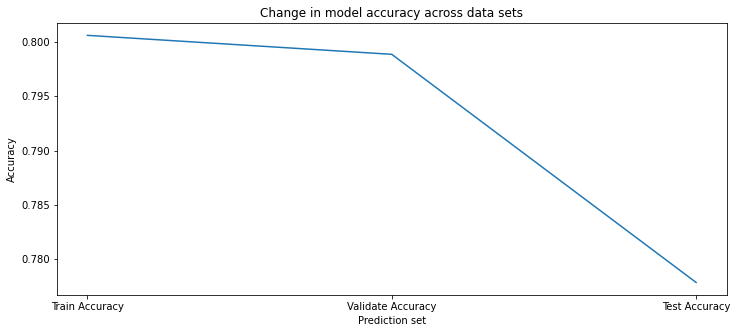

In [62]:
#graphically show the change in the accuracy
melted_df = test_df[['Model','Train Accuracy', 'Validate Accuracy', 'Test Accuracy']].melt(id_vars='Model')
melted_df
plt.figure(figsize=(12, 5))
sns.lineplot(x='variable', y='value', data = melted_df)
plt.title('Change in model accuracy across data sets')
plt.xlabel('Prediction set')
plt.ylabel('Accuracy')

This graph shows the change in the model accuracy for the train, validate and test data sets.  The overall fall change is $-0.02$.

Text(0, 0.5, 'Sensitivity')

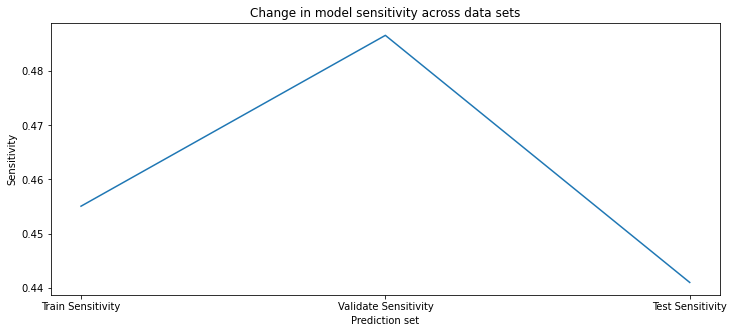

In [63]:
# graphically show the change in sensitivity
melted_df = test_df[['Model','Train Sensitivity', 'Validate Sensitivity', 'Test Sensitivity']].melt(id_vars='Model')
melted_df
plt.figure(figsize=(12, 5))
sns.lineplot(x='variable', y='value', data = melted_df)
plt.title('Change in model sensitivity across data sets')
plt.xlabel('Prediction set')
plt.ylabel('Sensitivity')

This graph shows the change in the model accuracy for the train, validate and test data sets.  The overall fall change is $-0.01$.

### Testing and Prediction Discussion

The decision tree model remains fairly consistent in its accuracy and sensitivity overall data sets.  With $0.77$ accuracy, the model remains significantly above a baseline model.

### Makeing a `predictions.csv`

In order to display the prediction of churn and its probability, the testing results are made into a dataframe object that is then saved to a `.csv` file.

In [64]:
#make an empty dataframe
predict_df = pd.DataFrame()
#add the data needed
predict_df['customer_id'] = test['customer_id']
predict_df['churn_prediction'] = predictions
#only the prediction to churn is needed
predict_df['prediction_probability'] = predictions_proba[:,1]

#save to a .csv file
predict_df.to_csv('predictions.csv')

predict_df

,customer_id,churn_prediction,prediction_probability
816,1194-HVAIF,0,0.452333
1488,2194-IIQOF,0,0.011076
4796,6738-ISCBM,0,0.110092
3213,4609-KNNWG,0,0.011076
5026,7064-JHXCE,0,0.011076
...,...,...,...
1234,1832-PEUTS,0,0.071111
1279,1899-VXWXM,0,0.211538
2281,3258-ZKPAI,0,0.071111
2536,3633-CDBUW,0,0.110092


<a href='#contents'>To Top</a>

<a href='#evaluation'>Prev: Evaluating the model</a> - <a href='#keytakeaways'>Beginning:Key Take Aways</a>
## Recommendations <a name='recommendations'></a>
As stated in the discussion about <a href='#modeldiscussion'> choosing the best model</a>, customers churn because their willingness to pay for the service they have is lower than their monthly payment.  However, any solution must also cost below the cost to replace the customer.  Some of the following could possibly meet business needs:

Easiest/immediate solutions:
- Offer discounts to current customers who are likely to churn. These can be based on the following:
    - Move to automatic billing, or a longer contract.
    - Demographic discounts (senior discount).
    - Loyalty discounts for x months with the company.
Intermediate solutions:
- Contact customers who are likely to churn and get them service that meets their need
    - Some may only need DSL level service.
    - Offer additional services (online backup, device protection, etc.) to customers who want to keep fiber optic.
Long term solutions:
- Partner with companies for a loyalty reward program.
- Offer intermediate levels of service; for example, DSL with discounted extras (online backup, technical help, etc).

In order to deploy these strategies, the model can be used in the call center to display the likelihood of a particular customer churning.  This can then empower customer service employees to tailor the services to certain customers. It could also help to determine if new customers are getting the service that they need.

## Final Conclusions <a name='conclusion'></a>
- High predictors of churn are the following:
    - Fiber optic service
    - Month-to-Month contracts
    - Electronic check payments
- Solutions:
    - Offer discounts to likely-to-churn customers
    - Offer additional services to customers
    
### Meeting the goals of the project
- The three major predictors of churn were Month-to-Month contracts, Fiber Optic service, and electronic checks
- The decision tree model is greater than $0.75$ accurate
- This report communicates these findings
    
### For further research
- This is a limited analysis, any future analysis should consider the relationship between additional services and churn (see appendix)
- Are demographic correlated with churn factors? For example, what customers are likely to have dependents/partners? Are these more likely to have fiber optic?
- See appendix for more discussion

<a href='#evaluation'>Prev: Evaluating the model</a> - <a href='#keytakeaways'>Beginning:Key Take Aways</a>

<a href='#contents'>To Top</a>

## Appendix <a name='appendix'></a>

### Proportion of customers churning in each category <a name='categoricalprops'></a>

Consider the churn for each subset of the categorical data.  Then conisder the categories with churn that is at least $0.1$ more than the overall churn rate.

In [65]:
#get list of categorical data
cat_var = train.dtypes[train.dtypes == 'object'].index.to_list()
cat_var.remove('customer_id')
cat_var.append('senior_citizen')

#now get the proportion of churn for each one
outputs = []
for cat in cat_var:
    for subcat in list(train[cat].unique()):
        prop = (train[train[cat] == subcat].churn == 'Yes').mean()  
        sample_prop = train[train[cat] == subcat].shape[0]/train.shape[0]
        output = {
            'category':cat,
            'subcategory':subcat,
            'churn_rate':prop,
            'prop_in_sample': sample_prop
        }
        outputs.append(output)
churn_rates = pd.DataFrame(outputs)

In [66]:
#consider churn rates at least 0.1 above the general churn rate
high_churn_cats = churn_rates[churn_rates.churn_rate > proportion_churn*1.1].sort_values('churn_rate')
high_churn_cats

,category,subcategory,churn_rate,prop_in_sample
8,multiple_lines,Yes,0.292990,0.423927
28,streaming_movies,Yes,0.293965,0.391415
4,dependents,No,0.313297,0.697231
2,partner,No,0.327084,0.514859
29,paperless_billing,Yes,0.335628,0.590297
26,streaming_movies,No,0.345978,0.388367
23,streaming_tv,No,0.351840,0.393447
18,device_protection,No,0.393385,0.430023
16,online_backup,No,0.397171,0.431039
21,tech_support,No,0.416882,0.490475


*Discussion*

The following categories: `streaming_movies`, `streaming_tv`, `device_protection`, `online_backup`, `tech_support`, and `online_security` can all be considered additional services. In 6 out of the 7, the customers do not subscribe to the service.  Adding these services might decrease churn rate among customers.

Consider online security churn rate:

In [67]:
churn_rates[churn_rates.category=='online_security']

,category,subcategory,churn_rate,prop_in_sample
11,online_security,Yes,0.141493,0.292609
12,online_security,No internet service,0.073818,0.220218
13,online_security,No,0.427007,0.487173


The churn rate for those with online security is significantly lower than the rate for all customers. Moreover, the majority of customers do not use the service.

<a href='#contents'>To Top</a>

### Hypothesis testing information

Consider teh combinations of every categorical variable and do a $χ^2$ test.

In [68]:
# do a chi^2 for every combination of categorical variable
outputs = []

alpha = 0.05

for x in itertools.combinations(cat_var, 2):
    obs = pd.crosstab(train[x[0]], train[x[1]])
    chi2, p, degf, expected = stats.chi2_contingency(obs)
    output = {
        'test_categories':f"{x[0]} x {x[1]}",
        'chi2': chi2,
        'p_val': p,
        'reject_null':p < alpha
    }
    outputs.append(output)
chi_tests = pd.DataFrame(outputs)

In [69]:
chi_tests[(chi_tests.reject_null == True) & (chi_tests.test_categories.str.contains('churn'))].sort_values('p_val')

,test_categories,chi2,p_val,reject_null
126,churn x contract_type,664.657249,4.693667e-145,True
76,online_security x churn,510.520615,1.386300e-111,True
103,tech_support x churn,460.871935,8.373959e-101,True
128,churn x internet_service_type,439.766148,3.206227e-96,True
127,churn x payment_type,338.485229,4.643588e-73,True
86,online_backup x churn,326.015433,1.609342e-71,True
95,device_protection x churn,314.354955,5.478843e-69,True
110,streaming_tv x churn,226.175317,7.702893e-50,True
116,streaming_movies x churn,220.438256,1.356566e-48,True
121,paperless_billing x churn,141.364215,1.339372e-32,True


This supports the conclusion in the <a href='#categoricalprops'>previous section</a> that service categories such as `online_security` are drivers of churn.

<a href='#contents'>To Top</a>

### Hypothesis testing for numeric columns

In [70]:
# compare churn and non churn for numeric data
# tenure and total_charges are not normal, use a mann whitney
# two sided test to see that they are different

alpha = 0.05
num_col = ['tenure', 'monthly_charges', 'total_charges']

telco_churn = train[train.churn == 'Yes']
telco_nochurn = train[train.churn == 'No']

cols = []
rej = []
p_val = []

for col in num_col:
    cols.append(f"churn x {col}")
    #compare variance
    churn_series = telco_churn[col]
    nochurn_series = telco_nochurn[col]
    #now do the mw test
    t, p = stats.mannwhitneyu(churn_series, nochurn_series, alternative= 'two-sided')
    reject = p/2 < alpha
    rej.append(reject)
    p_val.append(p)

mannw_test = {
    'columns': cols,
    'reject?': rej,
    'p-value':p_val
}
mannw_test = pd.DataFrame(mannw_test)
mannw_test#[mannw_test['reject?']==True].sort_values('p-value')

,columns,reject?,p-value
0,churn x tenure,True,1.746209e-117
1,churn x monthly_charges,True,4.601430e-32
2,churn x total_charges,True,2.346810e-46


In [71]:
#monthly charges might be considered normal.
churn_series = telco_churn['monthly_charges']
nochurn_series = telco_nochurn['monthly_charges']
l_t, l_p = stats.levene(churn_series, nochurn_series)
levene_bool = not l_p < alpha
    #now do the t test
t, p = stats.ttest_ind(churn_series, nochurn_series, equal_var= levene_bool)
p/2 < alpha, p

(True, 2.460130776937842e-43)

<a href='#contents'>To Top</a>

### Choosing model hyperparameters

A series of different models were used to determine the best hyperparameters.  The best model from each algorithm was chosen for the final report.

In [72]:
# make the models
DT_2 = DecisionTreeClassifier(max_depth = 2, random_state = rand_seed)
DT_3 = DecisionTreeClassifier(max_depth = 3, random_state = rand_seed)
DT_4 = DecisionTreeClassifier(max_depth = 4, random_state = rand_seed)
RF_5_7 = RandomForestClassifier(min_samples_leaf = 5, max_depth = 7, random_state = rand_seed)
RF_6_6 = RandomForestClassifier(min_samples_leaf = 6, max_depth = 6, random_state = rand_seed)
RF_9_9 = RandomForestClassifier(min_samples_leaf = 9, max_depth = 9, random_state = rand_seed)
KNN_17 = KNeighborsClassifier(n_neighbors=17)
KNN_19 = KNeighborsClassifier(n_neighbors=19)
KNN_21 = KNeighborsClassifier(n_neighbors=21)
logit_lbfgs = LogisticRegression(random_state = rand_seed, max_iter = 200, solver='lbfgs')
logit_newton_cg = LogisticRegression(random_state = rand_seed, max_iter = 200, solver='newton-cg')
logit_liblinear = LogisticRegression(random_state = rand_seed, max_iter = 200, solver = 'liblinear')

models = [
    {
        'name':'Decision Tree 2',
        'model':DT_2
    },
    {
        'name': 'Decision Tree 3',
        'model':DT_3
    },
    {
        'name': 'Decision Tree 4',
        'model':DT_4
    },
    {
        'name': 'Random Forest 5 7',
        'model':RF_5_7
    },
    {
        'name':'Random Forest 6 6',
        'model':RF_6_6
    },
    {
        'name':'Random Forest 9 9',
        'model':RF_9_9
    },
    {
        'name':'KN Neighbors 17',
        'model':KNN_17
    },
    {
        'name':'KN Neighbors 19',
        'model':KNN_19
    },
    {
        'name':'KN Neighbors 21',
        'model':KNN_21
    },
    {
        'name':'Logistic Regression lbfgs',
        'model':logit_lbfgs
    },
    {
        'name':'Logistic Regression newton-cg',
        'model':logit_newton_cg
    },
    {
        'name':'Logistic Regression liblinear',
        'model':logit_liblinear
    }
]

In [73]:
#train the models and make predictions on validate
outputs = []
for model in models:
    model['model'] = model['model'].fit(X_train, y_train)
    y_pred_train = model['model'].predict(X_train)
    metrics_dict_train = metrics.classification_report(y_train, y_pred_train, output_dict = True)
    y_pred = model['model'].predict(X_validate)
    metrics_dict = metrics.classification_report(y_validate, y_pred, output_dict = True)
    output = {
        'model': model['name'],
        'train accuracy': metrics_dict_train['accuracy'],
        'train recall':metrics_dict['1']['recall'],
        'validate accuracy': metrics_dict['accuracy'],
        'validate recall':metrics_dict['1']['recall'],
        'better_than_baseline':metrics_dict['accuracy'] > baseline_accuracy
    }
    outputs.append(output)

In [74]:
pd.DataFrame(outputs).sort_values(['train accuracy', 'validate accuracy']).set_index('model')

,train accuracy,train recall,validate accuracy,validate recall,better_than_baseline
model,,,,,
Decision Tree 2,0.794006,0.403743,0.796020,0.403743,True
Decision Tree 3,0.794006,0.403743,0.796020,0.403743,True
KN Neighbors 21,0.794260,0.414439,0.789623,0.414439,True
KN Neighbors 19,0.796800,0.409091,0.786780,0.409091,True
KN Neighbors 17,0.799340,0.425134,0.792466,0.425134,True
Decision Tree 4,0.800610,0.486631,0.798863,0.486631,True
Logistic Regression lbfgs,0.802896,0.585561,0.808102,0.585561,True
Logistic Regression liblinear,0.802896,0.574866,0.809524,0.574866,True
Logistic Regression newton-cg,0.803404,0.585561,0.809524,0.585561,True


*Note*: the differences are marginal, but they all are greater than the baseline model.

<a href='#contents'>To Top</a>